In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
import pickle

In [55]:
fraud_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train-1542865627584.csv')
bene_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train_Beneficiarydata-1542865627584.csv')
outpatient_tr = pd.read_csv('https://media.githubusercontent.com/media/kislay960/data/master/Train_Outpatientdata-1542865627584.csv')
inpatient_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train_Inpatientdata-1542865627584.csv')

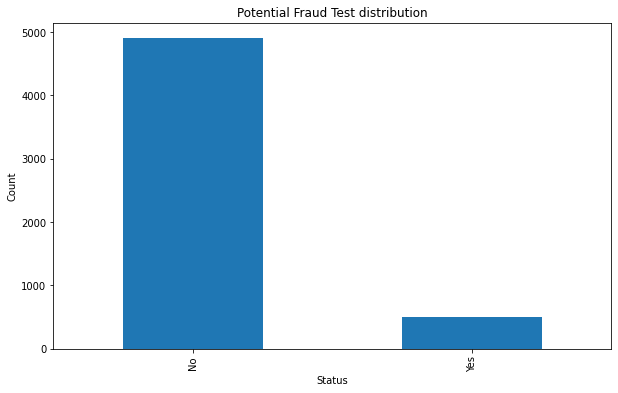

In [56]:
plt.title("Potential Fraud Test distribution")
fraud_tr.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

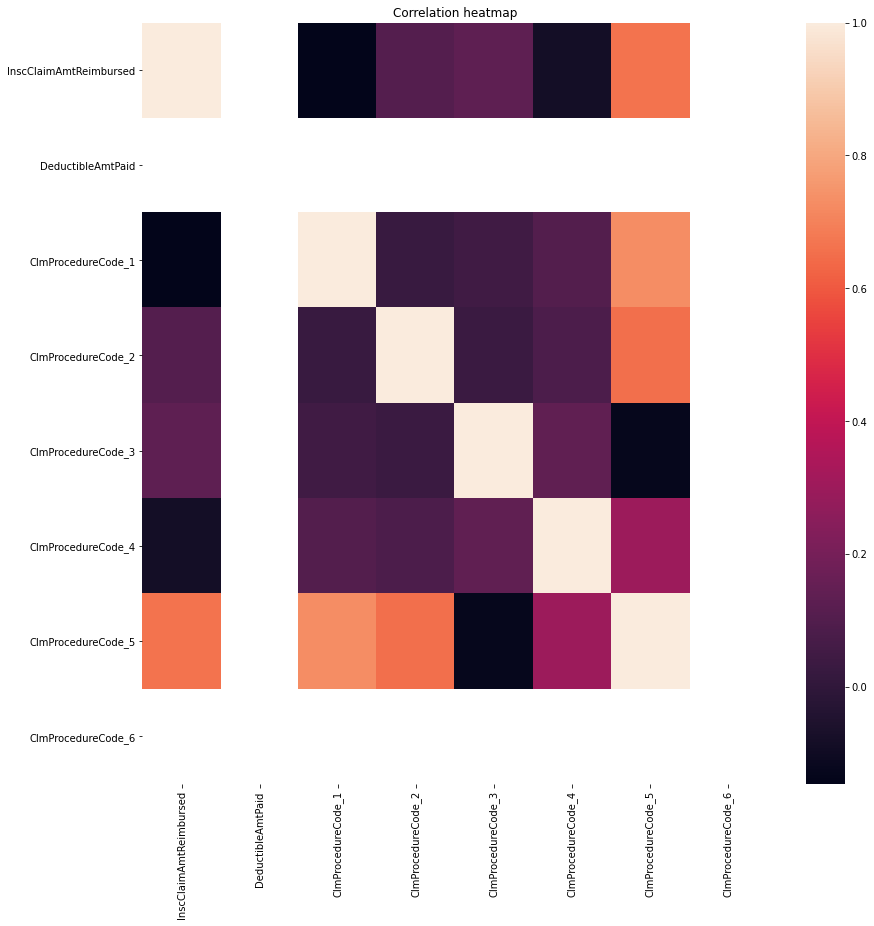

In [57]:
plt.figure(figsize=(14,14))
plt.title('Correlation heatmap')
sns.heatmap(inpatient_tr.corr())
plt.show()

In [58]:
flag=True
df2=pd.DataFrame()
df2=bene_tr[bene_tr['Gender']>2]
df2=bene_tr[bene_tr['Gender']<1]
if df2.shape[0]!=0:
    print("please correct the discrepencies in gender column",df2)
    flag=False

df2=pd.DataFrame()
df2=bene_tr[bene_tr['State']>54]
df2=bene_tr[bene_tr['State']<1]
if df2.shape[0]!=0:
    print("please correct the discrepencies in states column",df2)
    flag=False

df2=pd.DataFrame()
df2=bene_tr[bene_tr['County']>999]
df2=bene_tr[bene_tr['County']<0]
if df2.shape[0]!=0:
    print("please correct the discrepencies in Countries column \n",df2)
    flag=False

df2=pd.DataFrame()
df2=inpatient_tr[inpatient_tr['ClaimID'].duplicated()]
if df2.shape[0]!=0:
    print("please correct the discrepencies in Claimid as multiple peoples have same Claimid: \n",df2)
    flag=False

In [59]:
if flag:
    print("No discrepancies found")

No discrepancies found


In [60]:
bene_tr.head()

BeneID         DOB  ... OPAnnualReimbursementAmt  OPAnnualDeductibleAmt
0  BENE11001  1943-01-01  ...                       60                     70
1  BENE11002  1936-09-01  ...                       30                     50
2  BENE11003  1936-08-01  ...                       90                     40
3  BENE11004  1922-07-01  ...                     1810                    760
4  BENE11005  1935-09-01  ...                     1790                   1200

[5 rows x 25 columns]

**TASK 2**

In [61]:
overpmnt = pd.DataFrame([bene_tr.BeneID, bene_tr.IPAnnualReimbursementAmt, bene_tr.IPAnnualDeductibleAmt, bene_tr.OPAnnualReimbursementAmt, bene_tr.OPAnnualDeductibleAmt]).transpose()

In [62]:
overpmnt.head()

BeneID  ... OPAnnualDeductibleAmt
0  BENE11001  ...                    70
1  BENE11002  ...                    50
2  BENE11003  ...                    40
3  BENE11004  ...                   760
4  BENE11005  ...                  1200

[5 rows x 5 columns]

In [63]:
overpmnt['Bill'] = overpmnt['IPAnnualReimbursementAmt'] + overpmnt['OPAnnualReimbursementAmt']
overpmnt['Reimbursement'] = overpmnt['IPAnnualDeductibleAmt'] + overpmnt['OPAnnualDeductibleAmt']

In [64]:
overpmnt.head()

BeneID IPAnnualReimbursementAmt  ...   Bill Reimbursement
0  BENE11001                    36000  ...  36060          3274
1  BENE11002                        0  ...     30            50
2  BENE11003                        0  ...     90            40
3  BENE11004                        0  ...   1810           760
4  BENE11005                        0  ...   1790          1200

[5 rows x 7 columns]

In [65]:
overpmnt.drop(overpmnt.columns[[1,2,3,4]], axis=1, inplace=True)
overpmnt.head()

BeneID   Bill Reimbursement
0  BENE11001  36060          3274
1  BENE11002     30            50
2  BENE11003     90            40
3  BENE11004   1810           760
4  BENE11005   1790          1200

In [66]:

overpmnt['Overpayment'] = np.where(overpmnt['Bill']>overpmnt['Reimbursement'],True,False)

In [67]:
overpmnt.head()

BeneID   Bill Reimbursement  Overpayment
0  BENE11001  36060          3274         True
1  BENE11002     30            50        False
2  BENE11003     90            40         True
3  BENE11004   1810           760         True
4  BENE11005   1790          1200         True

**TASK 3**

In [68]:
In_Provider=pd.DataFrame([inpatient_tr['Provider'].value_counts().index,inpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Inpatient_Claim_Number'},axis=1)
Out_Provider=pd.DataFrame([outpatient_tr['Provider'].value_counts().index,outpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Outpatient_Claim_Number'},axis=1)
provider_claimnumber=pd.merge(In_Provider,Out_Provider,on='Provider',how='outer')
inreimburse_by_provider=inpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
inreimburse_temp1=pd.DataFrame([inreimburse_by_provider.index,inreimburse_by_provider])
inreimburse_temp2=inreimburse_temp1.transpose()
In_Provider_Claim=inreimburse_temp2.rename({0:'Provider',1:'Inpatient_Claim_Amount'},axis=1)
outreimburse_by_provider=outpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
outreimburse_temp=pd.DataFrame([outreimburse_by_provider.index,outreimburse_by_provider]).transpose()
#outreimburse_temp2=outreimburse_temp.transpose()
Out_Provider_Claim=outreimburse_temp.rename({0:'Provider',1:'Outpatient_Claim_Amount'},axis=1)
provider_claimamount=pd.merge(In_Provider_Claim,Out_Provider_Claim,on='Provider',how='outer')
provider_list1=pd.merge(fraud_tr,provider_claimnumber,on='Provider',how='outer')
provider_list2=pd.merge(provider_list1,provider_claimamount,on='Provider',how='outer')

In [69]:
provider_list2

Provider PotentialFraud  ... Inpatient_Claim_Amount Outpatient_Claim_Amount
0     PRV51001             No  ...                  97000                    7640
1     PRV51003            Yes  ...                 573000                   32670
2     PRV51004             No  ...                    NaN                   52170
3     PRV51005            Yes  ...                    NaN                  280910
4     PRV51007             No  ...                  19000                   14710
...        ...            ...  ...                    ...                     ...
5405  PRV57759             No  ...                    NaN                   10640
5406  PRV57760             No  ...                    NaN                    4770
5407  PRV57761             No  ...                    NaN                   18470
5408  PRV57762             No  ...                    NaN                    1900
5409  PRV57763             No  ...                    NaN                   43610

[5410 rows x 6 columns]

In [70]:
provider_clean=provider_list2.fillna(0)
y = provider_clean['PotentialFraud'].values
X = provider_clean.drop(['PotentialFraud','Provider'], axis=1).values

In [71]:
warnings. filterwarnings('ignore')

In [72]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train1, y_train1)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 93.13429974590714%


In [73]:
print(y_train1)

['No' 'Yes' 'No' ... 'Yes' 'No' 'No']


In [75]:
filename = 'task3.sav'
pickle.dump(knn_cv,open(filename,'wb'))

**TASK 4**

In [22]:
provider_clean

Provider PotentialFraud  ...  Inpatient_Claim_Amount  Outpatient_Claim_Amount
0     PRV51001             No  ...                   97000                     7640
1     PRV51003            Yes  ...                  573000                    32670
2     PRV51004             No  ...                       0                    52170
3     PRV51005            Yes  ...                       0                   280910
4     PRV51007             No  ...                   19000                    14710
...        ...            ...  ...                     ...                      ...
5405  PRV57759             No  ...                       0                    10640
5406  PRV57760             No  ...                       0                     4770
5407  PRV57761             No  ...                       0                    18470
5408  PRV57762             No  ...                       0                     1900
5409  PRV57763             No  ...                       0                    43610

[5410 rows x 6 columns]

In [23]:
provider_clean.head()

Provider PotentialFraud  ...  Inpatient_Claim_Amount  Outpatient_Claim_Amount
0  PRV51001             No  ...                   97000                     7640
1  PRV51003            Yes  ...                  573000                    32670
2  PRV51004             No  ...                       0                    52170
3  PRV51005            Yes  ...                       0                   280910
4  PRV51007             No  ...                   19000                    14710

[5 rows x 6 columns]

In [24]:
provider_clean['Mode_of_Payment'] = np.where(provider_clean['Inpatient_Claim_Number']<3,'Check','EFT')

In [25]:
provider_clean

Provider PotentialFraud  ...  Outpatient_Claim_Amount  Mode_of_Payment
0     PRV51001             No  ...                     7640              EFT
1     PRV51003            Yes  ...                    32670              EFT
2     PRV51004             No  ...                    52170            Check
3     PRV51005            Yes  ...                   280910            Check
4     PRV51007             No  ...                    14710              EFT
...        ...            ...  ...                      ...              ...
5405  PRV57759             No  ...                    10640            Check
5406  PRV57760             No  ...                     4770            Check
5407  PRV57761             No  ...                    18470            Check
5408  PRV57762             No  ...                     1900            Check
5409  PRV57763             No  ...                    43610            Check

[5410 rows x 7 columns]

In [26]:
y = provider_clean['Mode_of_Payment'].values
X = provider_clean.drop(['PotentialFraud','Provider','Mode_of_Payment'], axis=1).values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 96.83112410814806%


In [28]:
finalfile = 'final.sav'
pickle.dump(knn, open(finalfile,'wb'))

**FINAL RUNNABLE FILES**

In [100]:
#!pip install anvil-uplink
import anvil.server
anvil.server.connect('UMMTGATMCZUEJKKO3Z23YLBY-ULR7UU7Y4F6PXIRD')

In [102]:
@anvil.server.callable
def task_3(t,t1,t2,t3):
  inclaimnumber=int(t)
  outclaimnumber=int(t1)
  inclaimamount=int(t2)
  outclaimamount=int(t3)
  temp=[inclaimnumber,outclaimnumber,inclaimamount,outclaimamount]
  return(("The model prediction for potential Appeals & Grievances (A&G) inflow and processing : ",loaded_model1.predict([temp])[0]))

In [76]:
loaded_model1 = pickle.load(open(filename, 'rb'))

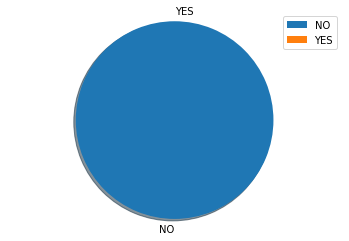

In [94]:
# To be added in the website
fig1, ax1 = plt.subplots()
labels='NO','YES'
sizes=[loaded_model1.predict_proba([temp])[0][0],loaded_model1.predict_proba([temp])[0][1]]
ax1.pie(sizes, labels=labels, shadow=True, startangle=90)
ax1.axis('equal')
plt.legend()
plt.show()